In [1]:
import cv2

import sys

sys.path.append('/scratch/mz2476/DL/project/')

import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
# matplotlib.rcParams['font.size'] = 20

from ssl_project.data_loaders import plot_utils

import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from ssl_project.data_loaders.data_helper import UnlabeledDataset, LabeledDataset, FastLabeledDataset
from ssl_project.data_loaders.helper import collate_fn, draw_box
from ssl_project import constants

from ssl_project.preprocessing import top_down_segmentation
from ssl_project.utils import to_np
from ssl_project.paths import *

In [2]:
# import from model_loader
def get_transform_task1():
    return torchvision.transforms.ToTensor()
def get_transform_task2():
    return torchvision.transforms.ToTensor()

In [3]:
image_folder = PATH_TO_DATA
annotation_csv = PATH_TO_ANNOTATION

train_scene_idces = np.arange(106, 131)
val_scene_idces = np.arange(131, 134)

train_dataset = FastLabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=train_scene_idces,
    transform=get_transform_task1(),
    extra_info=False
    )
val_dataset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_scene_idces,
    transform=get_transform_task2(),
    extra_info=False
    )

# Plot probability map (using train data) and baseline

Baseline visualization is approximate for road.

In [5]:
target_car_maps_nWW = []
target_road_maps_nWW = []

for image_63hw, target, road_image, extra in train_dataset:
    target_car_maps_nWW.append(target["cars_map"][0])
    target_road_maps_nWW.append(road_image.float())
    
target_car_maps_nWW = torch.stack(target_car_maps_nWW)
target_road_maps_nWW = torch.stack(target_road_maps_nWW)

target_car_maps_nWW.shape, target_road_maps_nWW.shape

(torch.Size([3150, 800, 800]), torch.Size([3150, 800, 800]))

In [4]:
cmap = plt.cm.Blues

In [6]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [20]:
def plot_prob_map(axis, title, mean_map_type_WW, vmax):
    axis.set_title(title)
    im = axis.imshow(mean_map_type_WW, cmap=cmap, 
                     vmin=0, vmax=vmax,
                    )
    axis.grid(linestyle="--")
    axis.scatter([400], [400], marker='x', s=100, c='r')

    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    return axis

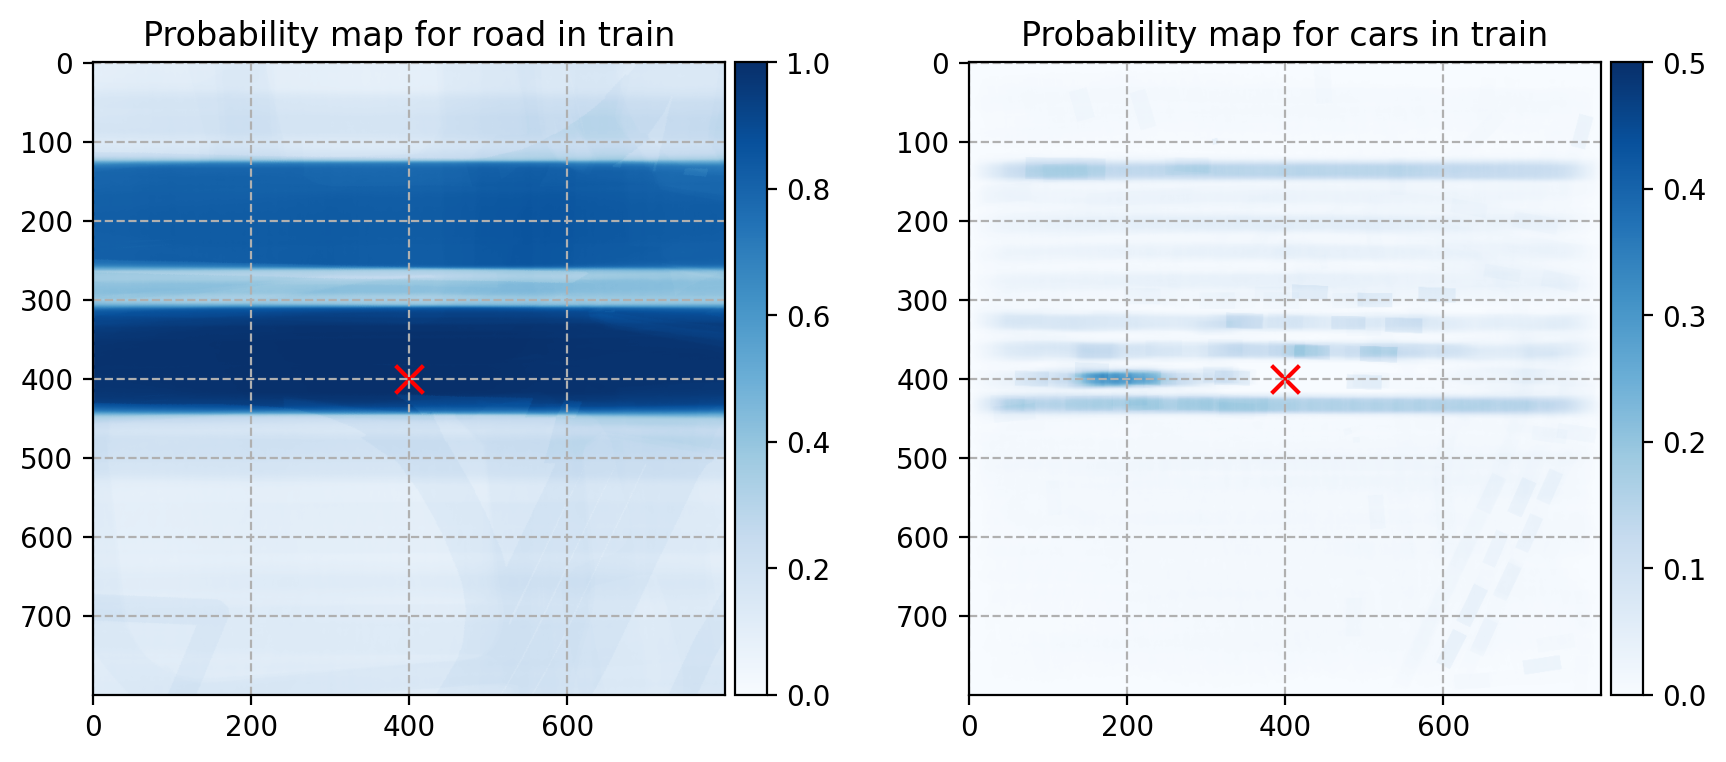

In [41]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
for axis, title, mean_map_type_WW, vmax in zip(
        axes, 
        ["Probability map for road in train", "Probability map for cars in train"],
        [target_road_maps_nWW.mean(axis=0), target_car_maps_nWW.mean(axis=0)],
        [1, 0.5]
    ):
    plot_prob_map(axis, title, mean_map_type_WW, vmax)
    
plt.subplots_adjust(wspace=0.3)

# plt.savefig("../report/probability_maps.png")


In [28]:
from ssl_project.vehicle_layout_prediction.bb_utils import get_baseline_raw_bbs

In [34]:
grid_bbs_k24 = get_baseline_raw_bbs(in_bb_space=True)

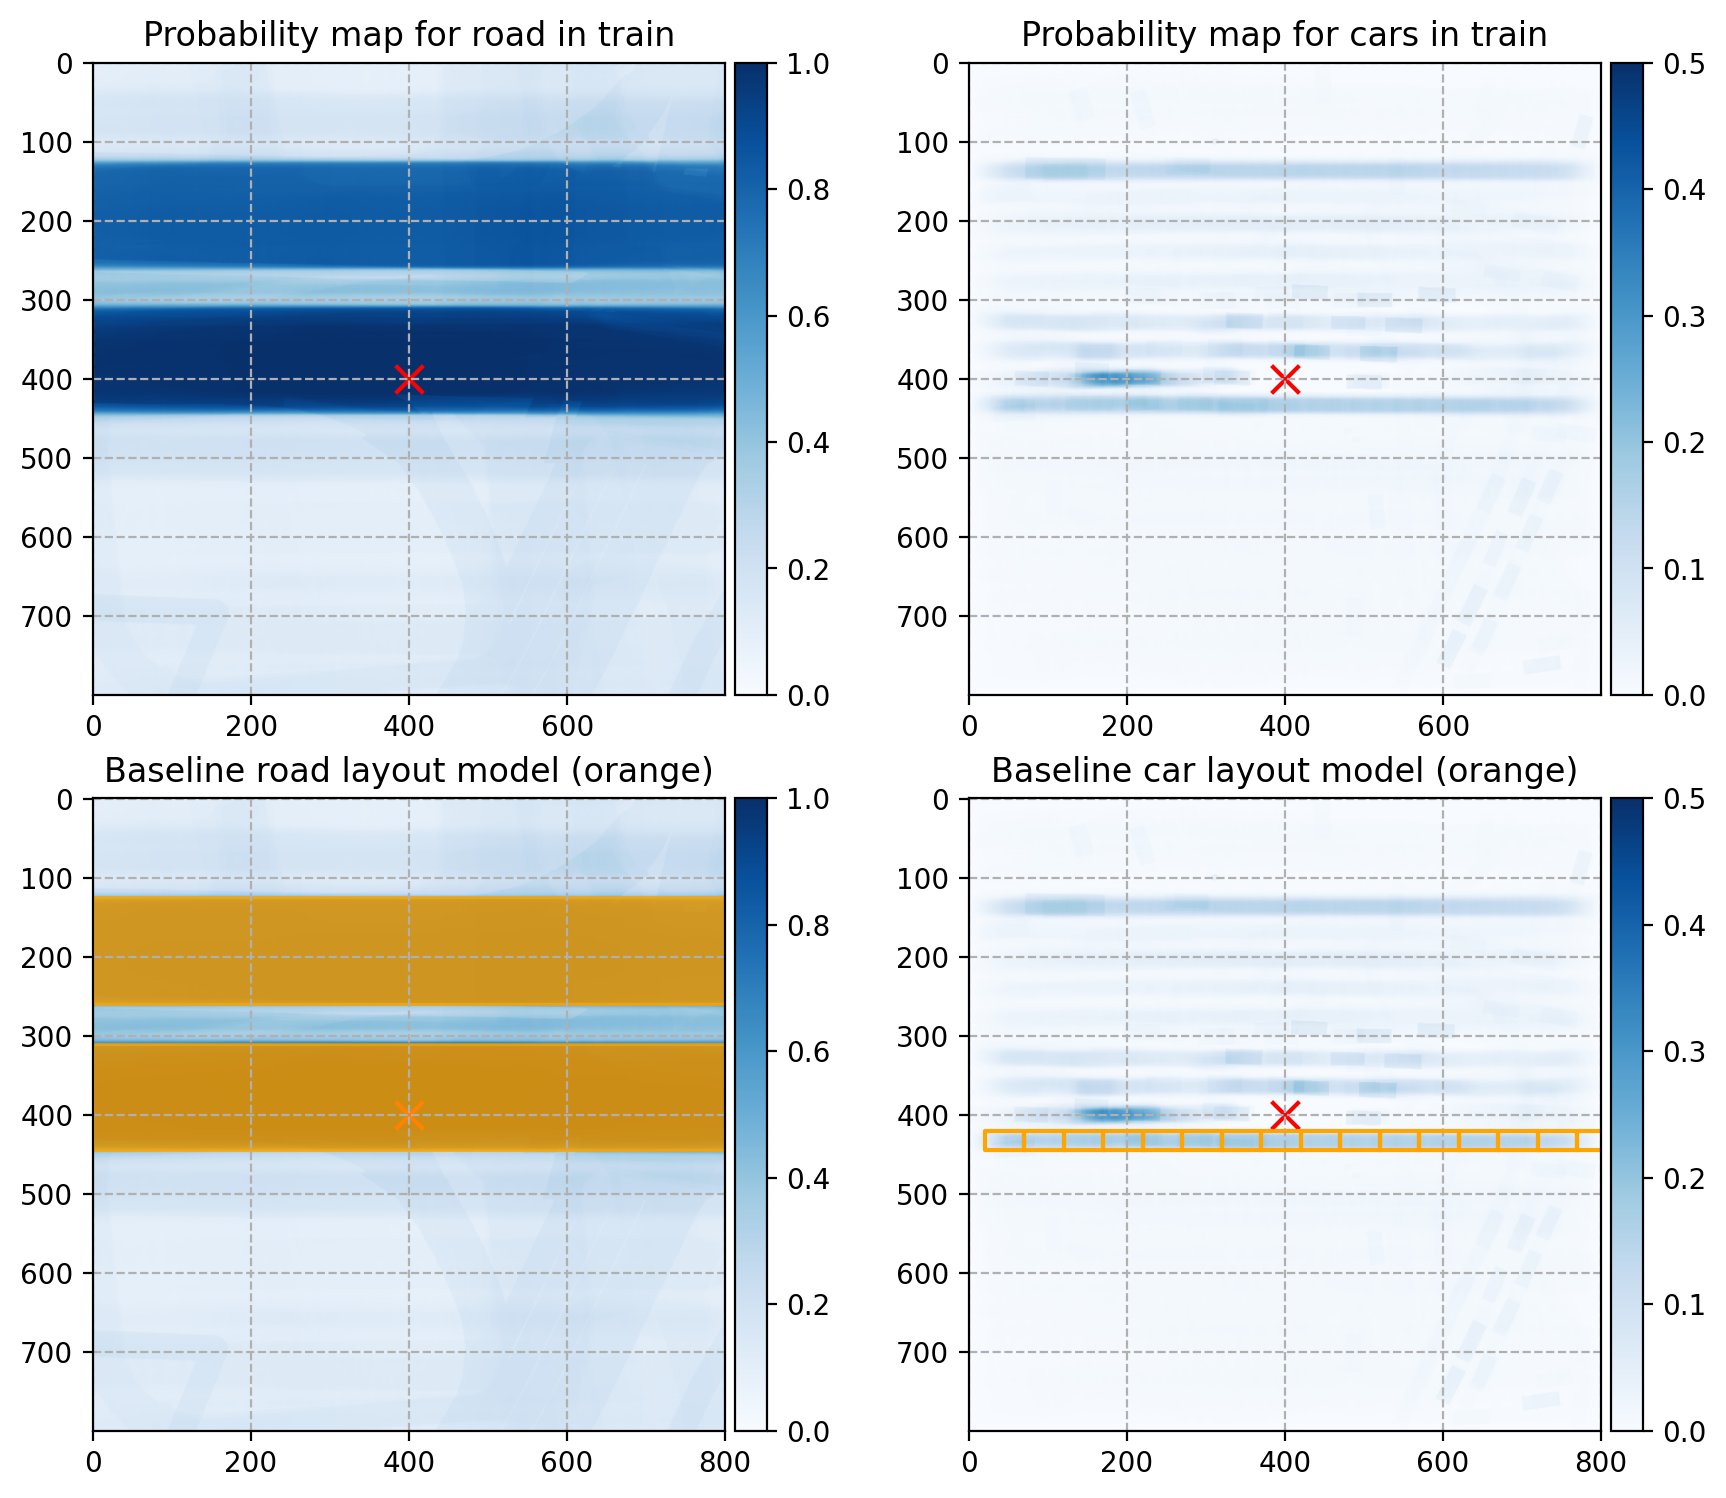

In [43]:
import matplotlib.patches as patches
from ssl_project.data_loaders.helper import draw_box

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2, figsize=(10, 10))


ax11 = plot_prob_map(ax11, "Probability map for road in train", target_road_maps_nWW.mean(axis=0), 1)

ax21 = plot_prob_map(ax21, "Baseline road layout model (orange)", target_road_maps_nWW.mean(axis=0), 1)
# Create a Rectangle patch
rect1 = patches.Rectangle((0,125),800,135,linewidth=1,edgecolor='orange',facecolor='orange',alpha=0.8)
rect2 = patches.Rectangle((0,310),800,135,linewidth=1,edgecolor='orange',facecolor='orange',alpha=0.8)
# Add the patch to the Axes
ax21.add_patch(rect1)
ax21.add_patch(rect2)
ax21.set_xlim(0, 800)

ax12 = plot_prob_map(ax12, "Probability map for cars in train", target_car_maps_nWW.mean(axis=0), 0.5)

ax22 = plot_prob_map(ax22, "Baseline car layout model (orange)", target_car_maps_nWW.mean(axis=0), 0.5)
for bb_24 in grid_bbs_k24:
    draw_box(ax22, bb_24, color="orange")
    
ax22.set_xlim(0, 800)
    
plt.subplots_adjust(wspace=0.3, hspace=-0.05)

plt.savefig("../report/probability_maps_and_baseline.png")